Import packages and functions

In [1]:
import sys
sys.path.append('../../')


from scripts.forecast import DataGenerator, make_photoz_bin_edges, compare_fisher_matrices
from scripts.luminosity_functions import def_agn_xlf
from scripts.utils import path2res_forecast, set_mpl
set_mpl()
%matplotlib inline




Set up tracer population parameters

In [2]:

fiducial_params = {'Omega_c': 0.25, 'Omega_b': 0.05,
                   'h': 0.7, 'sigma8': 0.8, 'n_s': 0.96,
                   'transfer_function': 'boltzmann_camb',
                   'baryons_power_spectrum': 'nobaryons',
                   'matter_power_spectrum': 'linear'}

fsky = 0.658
powspec_pars_dict_agn = {
    'slim': 1e-14,
    'sigma_0': 0.03,
    'f_fail': 0.1,
    'l_min': 10,
    'l_max': 500,
    'log_bins': 41,
    'fsky': fsky,
    'has_rsd': True,
    'use_weighed_bias': False,
    'density_multiplier': 1.3,
    'camb_llimber': 110,
    'xlf': def_agn_xlf,
    'use_camb': True,
    'delta_i': 3,
    'remove_ignored_cells': True,
}


SETNAME = 'AGN_optimistic_h_ns_prior'

zmin_agn = 0.5
zmax_agn = 2.5
k_photoz_agn = 1


bin_left_edges = make_photoz_bin_edges(
    zmin_agn, zmax_agn, k=k_photoz_agn, sigma_0=powspec_pars_dict_agn['sigma_0'])
powspec_pars_dict_agn['bin_left_edges'] = bin_left_edges


Run the data generator

In [3]:
datagen = DataGenerator(
                        fiducial_params=fiducial_params, set_name=SETNAME,)

datagen.invoke(
    **powspec_pars_dict_agn, plot_cell=False, plot_dndz=False)


Total AGN sources: 1914915 at fsky=0.658[27144 deg^2]
Photo-z parameters: self.sigma_0=0.03, self.f_fail=0.1
calculating CAMB...
CAMB calculation time: 1.8466579914093018


calc Covariance: 100%|██████████| 435/435 [00:02<00:00, 196.30it/s]


Compuute fisher matrix (it would be the input proposal distribution into MCMC)

Start Jacobian calculation (cosmological part): jac_step=0.0005, jac_order=2
Finished Jacobian calculation (cosmological part) in 30.84 seconds

AGN_optimistic_h_ns_prior h prior (0.05) n_s prior (0.01)
FoM: 1.63e+11
Omega_c: 0.250 +- 0.013 (5.3 %)
Omega_b: 0.050 +- 0.006 (12.0 %)
h: 0.700 +- 0.041 (5.9 %)
n_s: 0.960 +- 0.010 (1.0 %)
sigma_8: 0.800 +- 0.004 (0.5 %)
-------


(<Figure size 720x720 with 25 Axes>,
                                                    $\Omega_c$ $\Omega_b$  \
 AGN_optimistic_h_ns_prior h prior (0.05) n_s pr...       5.3%      12.0%   
 
                                                      $h$ $n_s$ $\sigma_8$  \
 AGN_optimistic_h_ns_prior h prior (0.05) n_s pr...  5.9%  1.0%       0.5%   
 
                                                       FoM  
 AGN_optimistic_h_ns_prior h prior (0.05) n_s pr...  11.21  )

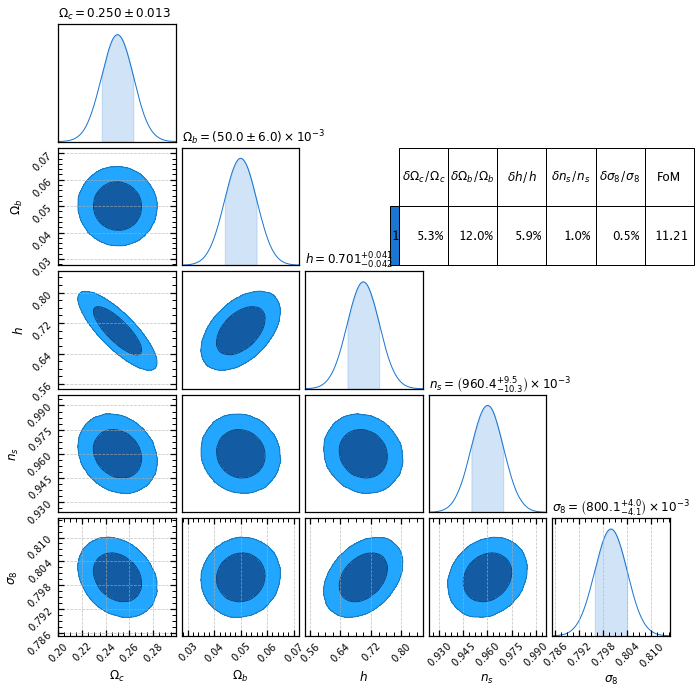

In [4]:
F_prior = datagen.get_Fisher_matrix()[0].add_prior_by_idx(2, 0.05).add_prior_by_idx(3, 0.01)
compare_fisher_matrices([F_prior])

Make `cobaya` input `yaml` file

In [5]:
from scripts.forecast import make_cobaya_input
from cobaya.model import get_model
from scripts.forecast import gaussian_loglike

make_cobaya_input(datagen, foldername=SETNAME, F =F_prior, fix_cov=True)

# Run cobaya
At this point one should run the chain using `cobaya-run`. See instructions in `results/data/mcmc/AGN_optimistic_h_ns_prior/readme.txt`

# compare Fisher and MCMC

import functions for comparison and load a fisher matix

In [18]:
from scripts.forecast import load_fisher, analyze_chain
from scripts.utils import  path2plots
import seaborn as sns
F_loaded = load_fisher(SETNAME)

#colors = ['k', sns.color_palette('Pastel2').as_hex()[3]]
colors = [sns.color_palette().as_hex()[0], sns.color_palette().as_hex()[2]]

corner_plot_args = {'linewidths': [1, 0.3], 'shade': [False, True],  'shade_alpha': [0.6, 0.4], 'label_font_size': 23, 'tick_font_size': 15, 'colors': colors, 'shade_gradient': 0.9, 'sigmas': [1,2],
'linestyles': ['--', '-'], 'legend_kwargs':{'title':r'AGN ($\sigma_0=0.03$; $f_{{\rm fail}}=0.1$)', 'fontsize': 22, 'title_fontsize': 22}}


#compare_fisher_matrices([F_loaded])
# AGN_optimistic_h_ns_prior h prior (0.05) n_s prior (0.01)
# FoM: 1.63e+11
# Omega_c: 0.250 +- 0.013 (5.3 %)
# Omega_b: 0.050 +- 0.006 (12.0 %)
# h: 0.700 +- 0.041 (5.9 %)
# n_s: 0.960 +- 0.010 (1.0 %)
# sigma_8: 0.800 +- 0.004 (0.5 %)

/Users/sdbykov/work/forecast_clustering/notebooks/mcmc_forecast/../../scripts/forecast.py:2168: UserWarning: Parameters of cosmology are default: [0.25, 0.05, 0.7, 0.96, 0.8] 
  warnings.warn(


plot the results: fisher vs. mcmc

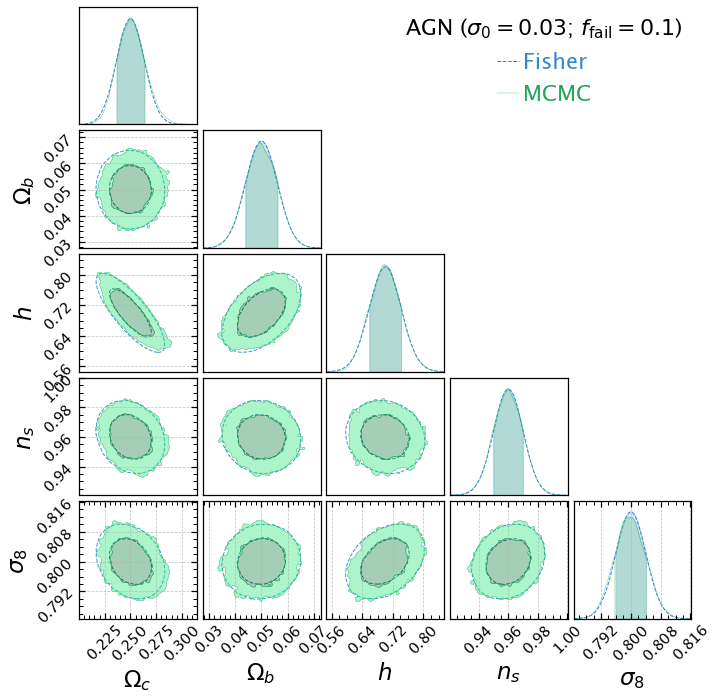

In [19]:
chain_res, chains_list, ch_cons = analyze_chain(SETNAME=SETNAME, Fs = [F_loaded],
filename = f'{path2plots}/cosmo_forecast/mcmc_vs_fisher.png',
 **corner_plot_args)


AGN_optimistic_h_ns_prior
FoM: 1.632e+11
Omega_c: 0.2500 +- 0.0133 (5.3 %)
Omega_b: 0.0500 +- 0.0060 (12.0 %)
h: 0.7000 +- 0.0414 (5.9 %)
n_s: 0.9600 +- 0.0098 (1.0 %)
sigma8: 0.8000 +- 0.0040 (0.5 %)
-------


(<Figure size 720x720 with 25 Axes>,
                           $\Omega_c$ $\Omega_b$   $h$ $n_s$ $\sigma8$    FoM
 AGN_optimistic_h_ns_prior       5.3%      12.0%  5.9%  1.0%      0.5%  11.21)

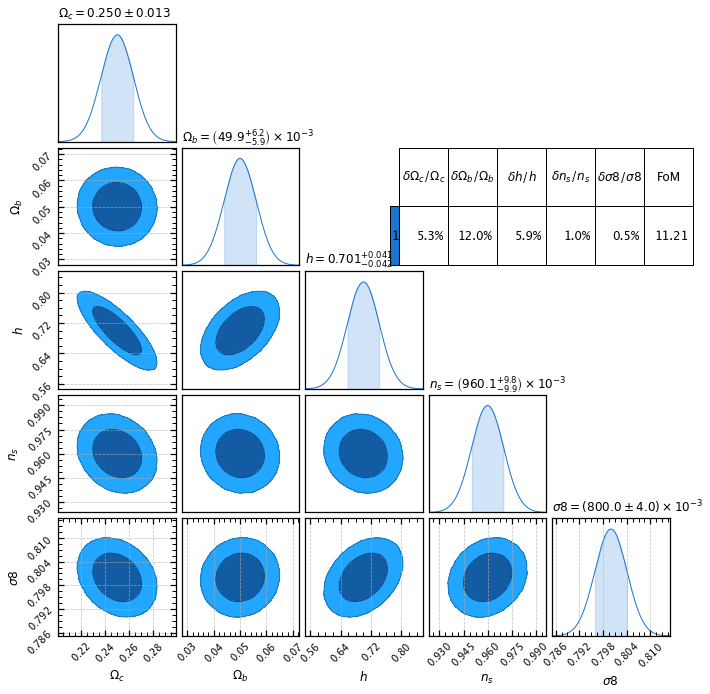

In [8]:
compare_fisher_matrices([F_loaded], precision=4)

In [9]:
print(ch_cons.analysis.get_latex_table(caption = 'MCMC vs. Fisher formalism'))

\begin{table}
    \centering
    \caption{MCMC vs. Fisher formalism}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_c$ & $\Omega_b$ & $h$ & $n_s$ & $\sigma_8$ \\ 
		\hline
		MCMC & $0.250^{+0.013}_{-0.014}$ & $\left( 49.9^{+6.3}_{-6.1} \right) \times 10^{-3}$ & $0.696^{+0.045}_{-0.038}$ & $\left( 959.4^{+10.3}_{-10.0} \right) \times 10^{-3}$ & $\left( 800.1^{+4.0}_{-4.5} \right) \times 10^{-3}$ \\ 
		\hline
    \end{tabular}
\end{table}
